In [1]:
from embeddings import load_embeddings
from sklearn.cluster import KMeans
import torch

#load embeddings-temporarily using small batch for testing-replace with dataset later
small_batch = torch.load('embeddings/all-MiniLM-L6-v2/00100000.pkl')

km = KMeans(n_clusters=4,random_state=0)
km.fit(small_batch)

KMeans(n_clusters=4, random_state=0)

In [2]:
#ensure clustering occurred for basic test
print(km.labels_)

[3 3 1 ... 0 1 3]


In [3]:
cluster_count = range(2, 6)

km_multiple = [KMeans(n_clusters=i) for i in cluster_count]
#jsquared errors for evaluating internal consistency in clusters
fits = [i.fit(small_batch).score(small_batch) for i in km_multiple]

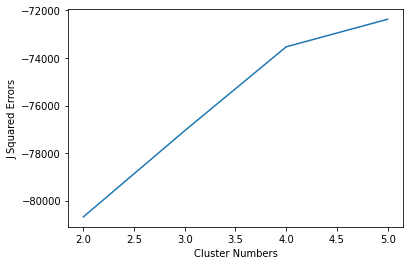

In [4]:
import matplotlib.pyplot as plt

plt.plot(cluster_count, fits)
plt.xlabel("Cluster Numbers")
plt.ylabel("J Squared Errors")
plt.show()

In [ ]:
import numpy as np

pred = km_multiple[4].fit(small_batch)
#We want to find the top feature vectors per cluster
#only consider unique "words"
labels = np.unique(pred)


In [ ]:
import torch
import pandas as pd
import json
# from torch.utils.data import DataLoader, SequentialSampler
from sklearn.preprocessing import MaxAbsScaler
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
from itertools import chain
from tqdm.auto import tqdm

from dataset import TwitterDataset
from autoencoders import load_encoder

def run_kmeans(
    timestamp_path,
    sentiment_path,
    embedding_path,
    encoder_path,
    encoder_type,
    whole_text_path = '',
    token_path = '',
    k = 5,
    n = 10,
    slice_size = '30m',
    save_path = ''
):

    dset = TwitterDataset(
        timestamp_path,
        sentiment_path,
        whole_text_path = whole_text_path,
        token_path =  token_path,
        embedding_path = embedding_path,
    )# torch.save(model.state_dict(),)

    model = load_encoder(encoder_path,encoder_type)
    for p in model.parameters():
        p.requires_grad = False
    model = model.cuda()

    print('successfully loaded dataset and encoder')

    # first we establish the start time of the dataset
    dset_start = pd.to_datetime(dset.timestamp[dset.sorted_idx][0])
    dset_end = pd.to_datetime(dset.timestamp[dset.sorted_idx][-1])

    print(f'our dataset goes from {dset_start} to {dset_end}')

    # pre calculate the time slices acccording to the parameter
    time_slices = [
        [
            dset_start + pd.Timedelta(slice_size) * i, 
            dset_start + pd.Timedelta(slice_size) * (i+1)
        ]
        for i in range(
            int(np.ceil((dset_end - dset_start)/pd.Timedelta(slice_size)))-1
        )
    ]


    # start = dset_start

    results = []

    for slice_beg,slice_end in tqdm(time_slices,desc=f'going over by {slice_size}'):
        # grab the dataset's sorted indexs using the time slices
        beg,end = dset.get_range(slice_beg,slice_end)
        original_idxs = dset[beg:end]['original_index']
        original_embs = dset[beg:end]['embedding'].cuda()
        reduced_embs = model.encoder(original_embs).cpu().numpy()
        scaled_embs = MaxAbsScaler().fit_transform(reduced_embs)

        kmeans = KMeans(n_clusters=5).fit(scaled_embs)

        one_slice_result = []
        for label in set(kmeans.labels_):
            centroid = kmeans.cluster_centers_[label]
            cluster = scaled_embs[kmeans.labels_ == label]
            top_N_closest = np.argsort(np.sqrt(((cluster - centroid)**2).sum(1)))[:n]
            word_count = dict(sorted(
                Counter(
                    chain(
                        *[
                            dset.tokens[i] 
                            for i in original_idxs[kmeans.labels_ == label]
                        ]
                    )
                ).items(),
                key= lambda x: x[1],
                reverse=True
            ))

            # one_slice_result[f'top_{n}_idxs_{label}'] = top_N_closest.tolist()
            # one_slice_result[f'wordcount_{label}'] = word_count
            one_slice_result.append({
                'label': label,
                f'top_{n}_idxs': top_N_closest,
                'word_count': word_count,
            })
        
        del original_embs,reduced_embs,scaled_embs
        # results.append(one_slice_result)

        
    json.dump(results,open(save_path/f'{k}_{slice_size}.json'))


In [ ]:
import clustering

run_kmeans('timestamp', 'sentiment', 'embeddings', '')
